# RBF version 


Lets define the RBF network

In [1]:
import pandas as pd
import scipy
import numpy as np
from sklearn.model_selection import train_test_split
# grid search, K-fold validation, fix seed
# find the model, but save the test loss and train loss for all the tried models
# create plot over parameter values and losses
import time

In [2]:
data = pd.read_csv('DATA (1).csv')
X_train, X_test, y_train, y_test = train_test_split(data[['x1','x2']], data[['y']], test_size=0.255, random_state=1990243)

In [3]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_tr = y_train.to_numpy()
y_te = y_test.to_numpy()

In [5]:
# sigma is a RBF spread parameter and simga > 0
def Gaussian(X, sigma):
    return np.exp(-(np.linalg.norm(X,axis = -1)/sigma)**2)

In [6]:
def RBF(W, args):
    sigma = args[1]
    X = args[2]
    C = W[0]
    v = W[1]
    #print(v.shape, Gaussian(X-C,sigma).shape)
    return np.matmul(v,Gaussian(X-C, sigma).T) 

In [7]:
def loss(W, args):
    N = args[0]
    if args[-1] == 1:
        a = args[-2]
        v = W
        regu = np.sum(v**2)
    elif args[-1] == 2:
        v = args[-2]
        a = W.reshape(1,N,2) 
        regu = np.sum(a**2) 
    else:
        v = W[-N:]
        a = W[:-N].reshape(1,N,2)
        regu = np.sum(a**2) + np.sum(v**2)
    y = args[3]
#    c = np.repeat(a,args[2].shape[0],axis=1).reshape((args[2].shape[0],N,2)).T
    c = np.tile(a,(args[2].shape[0],1)).reshape(args[2].shape[0],N,2)

    #regu = np.sum(a**2) + np.sum(v**2)
    loss = float((1/(2*len(args[2]))* np.sum((RBF((c,v), args) - y.T)**2, axis=1) + args[4]/2* regu)[0])
    #print(loss)
    return loss 

In [45]:
def grad_v(W, args):
    N = args[0]
    a = args[-2]
    v = W
    y = args[3]
#    c = np.repeat(a,args[2].shape[0],axis=1).reshape((args[2].shape[0],N,2)).T
    c = np.tile(a,(args[2].shape[0],1)).reshape(args[2].shape[0],N,2)
    phi = Gaussian(args[2]-c, args[1])
    grads = phi.T @ (phi @ v - y.reshape(-1)) + len(args[2])*args[4]*v
    return grads

In [56]:
def grad_both(W,args):
    N = args[0]
    v = W[-N:]
    a = W[:-N]
    args1 = (args[0],args[1], args[2], args[3], args[4], args[5],a.reshape(1,N,2), 0)
    v_g = grad_v(v,args1)
    args2 = (args[0],args[1], args[2], args[3], args[4], args[5],v, 0)
    c_g = grad_c(a,args2)
    return np.append(c_g.flatten(),v_g)

In [49]:
def grad_c(W, args):
    N = args[0]
    v = args[-2]
    a = W.reshape(1,N,2) 


    y = args[3]
    c = np.tile(a,(args[2].shape[0],1)).reshape(args[2].shape[0],N,2)
    main = RBF((c,v), args) - y.T  
    dervs = np.ones((N, 2)) 
    for i, vk in enumerate(v):
        buff = np.transpose(args[2], (1,0,2))[0] - np.repeat(np.array([c[0][i]]), len(args[2]), axis=0)
        #print( np.transpose(res, (1,0,2))[0] )
        buff2 = main @ (np.repeat(Gaussian(buff, args[1]),2,axis =0).reshape((args[2].shape[0],2)) * 2 * (buff)/(args[1]**2))
        #buff2 = main @ (Gaussian(buff, args[1])*2*np.sum(buff,axis=-1)/args[1]**2)
        
        dervs[i] = vk * buff2 + args[4]* c[0][i]
    return dervs.flatten()

In [11]:
def preproc(N, X_train, hold = False, seed = 123): #n: the nr of neurons; hold: if we want the centers to be chosen from X_train
    np.random.seed(seed)
    if hold == True:

       a = X_train[np.random.choice(np.arange(X_train.shape[0]), N, replace=False)].reshape(1,N,2) 
    else:
        a =  np.random.normal(size=(1, N, 2))
    #res = np.tile(X_train,(N,1)).reshape((X_train.shape[0],N,2))
    res = np.repeat(X_train,N,axis=0).reshape(X_train.shape[0],N,2)
    
    
    #C = np.repeat(a,X_train.shape[0], axis=1).reshape(X_train.shape[0],N,2)
    

    v = np.random.normal(size = N)
    return a,v,res # a:centers;v: weights; res: train data with compatible shape


In [12]:
def func(W, args): #for plotting
    N = args[0]
    v = W[-N:]
    a = W[:-N].reshape(1,N,2)
    #c = np.repeat(a,args[2].shape[0],axis=1).reshape((args[2].shape[0],N,2))
    c = np.tile(a,(args[2].shape[0],1)).reshape(args[2].shape[0],N,2)


    return RBF((c,v), args)

In [13]:
def test_error(W,  args):
    N = args[0]
    v = W[-N:]
    a = W[:-N].reshape(1,N,2)
    y = args[3]
    #c = np.repeat(a,args[2].shape[0],axis=1).reshape((args[2].shape[0],N,2))
    c = np.tile(a,(args[2].shape[0],1)).reshape(args[2].shape[0],N,2)


    return float((1/(2*len(args[2]))* np.sum((RBF((c,v), args) - y.T)**2, axis=1)))

In [62]:
## main loop
rho = 1e-3
sigma =0.5 
N = 50
seed = 123 #seed for weight initializtion
met = 'CG'
testing = 1 #which task are we testing

if testing == 1:
    C,V,res = preproc(N, X_train, seed= seed)
    print(len(res))
    shape = C.shape
    args = (N,sigma, res, y_tr, rho, shape,None, 0) #three modes: 0: both supervised; 1: centers unsupervised; 2:weights v unsupervised
    W = np.append(C.flatten(),V)
    print(loss(W, args))
    result_rbf = scipy.optimize.minimize(loss, W, args= (args,) , method=met, options = {"maxiter": 500})
elif testing == 2:
    C,V,res = preproc(N, X_train, 1, seed=seed)
    shape = C.shape
    args = (N,sigma, res, y_tr, rho, shape,C, 1) #three modes: 0: both supervised; 1: centers unsupervised; 2:weights v unsupervised
    W = V 
    print(loss(W, args))
    result_rbf = scipy.optimize.minimize(loss, W, args= (args,),jac=grad_v,  method=met)#, options = {"maxiter": 5})
else:
    C,V,res = preproc(N, X_train, 1, seed = seed)
    shape = C.shape
    args = (N,sigma, res, y_tr, rho, shape,C, 1) #three modes: 0: both supervised; 1: centers unsupervised; 2:weights v unsupervised
    W = V 
    print(loss(W, args))
    result_rbf = scipy.optimize.minimize(loss, W, args= (args,) ,jac=grad_v, method=met)#, options = {"maxiter": 5})
    print(result_rbf)
    args = (N,sigma, res, y_tr, rho, shape,result_rbf.x, 2) #three modes: 0: both supervised; 1: centers unsupervised; 2:weights v unsupervised
    W = C
    print(loss(W, args))
    result_rbf = scipy.optimize.minimize(loss, W, args= (args,) ,jac = grad_c, method=met)#, options = {"maxiter": 5})
print(result_rbf)




186
1.4807649398108196
     fun: 0.06655717339250054
     jac: array([-2.50432640e-06, -1.12038106e-06, -2.31899321e-07,  1.61118805e-07,
       -1.58976763e-06,  1.81235373e-06, -1.87009573e-06, -3.45520675e-07,
       -2.75485218e-06,  3.70666385e-07, -3.28756869e-07,  1.44354999e-07,
       -9.58330929e-07,  3.16370279e-06, -2.74740160e-07,  1.53668225e-07,
        3.03983688e-06, -3.94880772e-06, -2.75671482e-07,  1.52736902e-07,
       -1.37835741e-06, -1.08685344e-06, -8.10064375e-06, -4.62960452e-06,
       -2.42237002e-06,  1.01514161e-07, -2.36555934e-07, -1.42492354e-07,
       -5.35510480e-07,  1.10827386e-07,  6.59376383e-07, -1.00582838e-06,
       -6.21005893e-06,  1.42026693e-06, -2.82190740e-07,  1.51805580e-07,
        5.17908484e-06,  1.61398202e-06, -1.47521496e-06,  4.57279384e-07,
        1.17067248e-06,  1.49942935e-07, -2.83122063e-07,  1.51805580e-07,
       -2.33761966e-07,  1.59256160e-07,  6.52857125e-07,  1.08499080e-06,
        1.79465860e-06,  7.17118382e-

In [59]:
print(result_rbf.message)

Desired error not necessarily achieved due to precision loss.


In [60]:
###testing settings:
a,b, data_x = preproc(N,X_test)
data_y = y_te 
if testing == 2:
    W = np.append(C, result_rbf.x)
elif testing == 1:
    W = result_rbf.x
else:
    W = np.append(result_rbf.x, args[-2])

args = (N, sigma, data_x, data_y, rho, shape)
ter = test_error(W, args)
print(ter)

0.010823226451476368


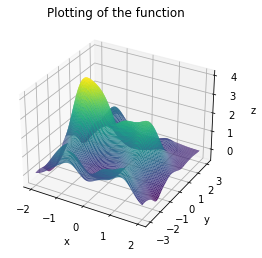

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 

def plotting( title='Plotting of the function'): #if you do not provide a title, 'Plotting...' will be used
    #create the object
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    n = 100
    #create the grid
    x = np.linspace(-2, 2, n) #create 50 points between [-5,5] evenly spaced  
    y = np.linspace(-3, 3, n)
    X, Y = np.meshgrid(x, y) #create the grid for the plot
    mixed =  np.vstack((X.flatten(),Y.flatten())).T #make the nxn grid into 2d array that can be fed into func
    a,b,res = preproc(N,mixed) #it gives my data matrix a shape that can be fed into RBF(as it has a specific shape)
    Z = func(W, (N, sigma,res,y_tr,rho ))#evaluate the function (note that X,Y,Z are matrix)
    Z = Z.reshape((n,n)) #now as there has been a lot of reshaping I will make back into nxn grid that can be given to poltter
    #print(Z.shape)


    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis', edgecolor='none')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(title)
    plt.show()

plotting()